In [1]:
# Import the required libraries.

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt
import os
import scipy.stats
from itertools import combinations
import gmplot 

from sklearn import manifold
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [2]:
# Read in the processed csv file created during data wrangling phase of project.

dataset=pd.read_csv('C:/Users/andre/Desktop/citibiki-data-tocluster.csv')

In [3]:
# Create a list of unique stations.

stations=dataset[['start station id','start station latitude','start station longitude']].copy()
stations.drop_duplicates(inplace=True)
stations.sort_values('start station id', ascending=True, inplace=True)
stations.reset_index(inplace=True)
stations.drop('index',axis=1,inplace=True)

In [4]:
# Create the coordinate list in radians 

xcoord=list(stations['start station latitude'])
ycoord=list(stations['start station longitude'])

xcoord_rad=[None]*822
ycoord_rad=[None]*822
coord_rad=[None]*822

for i in range(822):
    xcoord_rad[i]=radians(xcoord[i])
    ycoord_rad[i]=radians(ycoord[i])

for i in range(822):
    coord_rad[i]=[xcoord_rad[i],ycoord_rad[i]]

In [5]:
# Calculate pairwise Haversine distances and convert the distances to kilometers.

similarities=haversine_distances(coord_rad)
similarities=similarities * 6371000/1000  

In [6]:
# Multi-dimensional scaling to reduce the latitiude and longitude pairs for each station to one dimension.

mds= manifold.MDS(n_components=1, dissimilarity="precomputed")

pos = mds.fit(similarities).embedding_

In [7]:
# Normalize the station numbers and create a dictionary to use to assign these numbers to the dataset

normalized = (pos-min(pos))/(max(pos)-min(pos))
normalized=pd.DataFrame(normalized)
stations['normalized']=normalized
normdict=stations[['start station id','normalized']].copy()
normdict=normdict.set_index('start station id')
normdict=normdict['normalized'].rename('start station id')
normdict=normdict.to_dict()

In [8]:
# Generate the data set for k-means clustering.

cdata=dataset[['start station id','end station id','usertype','gender','age']].copy()

In [9]:
# Normalize the 'age' data.

cdata['age'] = (cdata['age']-min(cdata['age']))/(max(cdata['age'])-min(cdata['age']))

In [10]:
# Replace the 'start station id' and 'end station id' with the station location numbers obtained from MDS.

cdata['start station id']=cdata['start station id'].replace(to_replace = normdict, value=None)
cdata['end station id']=cdata['end station id'].replace(to_replace = normdict, value=None)

In [11]:
# Replace 'subscriber' with 1 and 'customer' with 0 in 'usertype' column.

utdict={'Subscriber':1,'Customer':0}
cdata['usertype']= cdata['usertype'].replace(to_replace = utdict, value=None)

In [12]:
# Set 'male' to 0 and 'female' to 1 in 'gender' column.

cdata['gender']=cdata['gender']-1

In [13]:
# rename 'station id' columns to reflect change to mds scaling to identify stations.

cdata.rename(columns={'start station id':'start station mds','end station id':'end station mds'}, inplace=True)

In [14]:
# Print out of data set for initial k-means clustering.

cdata.head(10)

,start station mds,end station mds,usertype,gender,age
0,0.795584,0.152101,1,0,0.500000
1,0.648768,0.631993,1,0,0.609375
2,0.834250,0.772945,1,0,0.250000
3,0.552688,0.578093,1,0,0.203125
4,0.530884,0.580173,1,0,0.375000
5,0.940812,0.989096,1,1,0.218750
6,0.157248,0.813312,1,0,0.250000
7,0.563208,0.229807,1,0,0.343750
8,0.225140,0.228818,1,1,0.203125
9,0.524806,0.509060,1,0,0.250000


In [15]:
# Convert data set from a data frame to a matrix.

x_cols = cdata.as_matrix()
x_cols = np.nan_to_num(x_cols)
print(x_cols.shape)
print(cdata.shape)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(8343761, 5)
(8343761, 5)


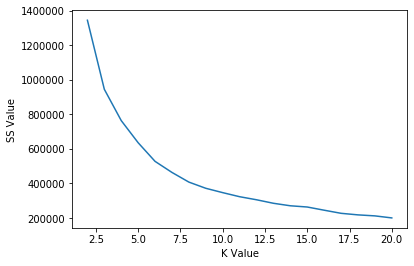

In [18]:
# Perform clustering with number of groups ranging from k=2 to k=20. Compute SS value for each k value and plot the elbow curve.
# cluster number assignments for each k value were saved to .csv files.

# elbows appear at k=3 and k=6.

# It should be noted that sillhouette scoring was attempted but it required too much computing time.

from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
assignment = np.zeros(shape=(19,8343761)) 
SS = np.zeros(shape=(19,1))

for i,b in enumerate(k):
    
    clusterer = KMeans(n_clusters=b, random_state=0)    
    cluster_labels = clusterer.fit_predict(x_cols)      
    assignment[i] = cluster_labels  
    SS[i] = clusterer.inertia_
           
plt.plot(k,SS)
plt.xlabel('K Value')
plt.ylabel('SS Value')
plt.show()

for i,b in enumerate(k):
    cluster=pd.DataFrame(assignment[i])
    cluster.columns=['cluster']
    cluster.to_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data{:.0f}.csv'.format(b), index=None)

In [16]:
# Re-create a data set that the cluster assignments for concatenation with the k-means cluster assignments.

cdata=dataset[['start station id','end station id','usertype','gender','age']].copy()
cdata['trip']=cdata['start station id'].map(str) +" to " + cdata['end station id'].map(str)

In [17]:
# clustering assignments were saved to .csv files as clustering from k=2 to k=20 takes over five hours and cannot be repeated
# every time the notebook is reset. This code reads the .csv files and assigns them to data frames.

cdata2=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data2.csv')
cdata3=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data3.csv')
cdata4=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data4.csv')
cdata5=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data5.csv')
cdata6=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data6.csv')
cdata7=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data7.csv')
cdata8=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data8.csv')
cdata9=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data9.csv')
cdata10=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data10.csv')

cdata11=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data11.csv')
cdata12=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data12.csv')
cdata13=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data13.csv')
cdata14=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data14.csv')
cdata15=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data15.csv')
cdata16=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data16.csv')
cdata17=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data17.csv')
cdata18=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data18.csv')
cdata19=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data19.csv')
cdata20=pd.read_csv('C:/Users/andre/Desktop/clustered/citibiki-20cluster-data20.csv')

In [18]:
# merge clustering data frame with cluster assignments obtained from k-means clustering.

cdata2=pd.concat([cdata,cdata2], axis=1)
cdata3=pd.concat([cdata,cdata3], axis=1)
cdata4=pd.concat([cdata,cdata4], axis=1)
cdata5=pd.concat([cdata,cdata5], axis=1)
cdata6=pd.concat([cdata,cdata6], axis=1)
cdata7=pd.concat([cdata,cdata7], axis=1)
cdata8=pd.concat([cdata,cdata8], axis=1)
cdata9=pd.concat([cdata,cdata9], axis=1)
cdata10=pd.concat([cdata,cdata10], axis=1)

cdata11=pd.concat([cdata,cdata11], axis=1)
cdata12=pd.concat([cdata,cdata12], axis=1)
cdata13=pd.concat([cdata,cdata13], axis=1)
cdata14=pd.concat([cdata,cdata14], axis=1)
cdata15=pd.concat([cdata,cdata15], axis=1)
cdata16=pd.concat([cdata,cdata16], axis=1)
cdata17=pd.concat([cdata,cdata17], axis=1)
cdata18=pd.concat([cdata,cdata18], axis=1)
cdata19=pd.concat([cdata,cdata19], axis=1)
cdata20=pd.concat([cdata,cdata20], axis=1)

In [19]:
# Cluster Describe Function - Provides description of the clusters that have been produced for a given k value.

def clusterdescribe(k,df):
    
    n=list(range(k))                 

    for i,b in enumerate(n):
        
        cluster=df[df['cluster']==b]   
    
        cluster1=cluster['age'].describe()
        cluster1=pd.DataFrame(cluster1)
        print('\nCluster Number {}.'.format(b))
        print('minimum age is {:.1f}.'.format(cluster1.loc['min','age']))
        #print('25 percentile age is {:.1f}.'.format(cluster1.loc['25%','age']))
        #print('median age is {:.1f}.'.format(cluster1.loc['50%','age']))
        print('mean age is {:.1f}.'.format(cluster1.loc['mean','age']))
        #print('75 percentile age is {:.1f}.'.format(cluster1.loc['75%','age']))
        print('maximum age is {:.1f}.'.format(cluster1.loc['max','age']))
    
        cluster1=cluster['gender'].value_counts()
        cluster1=pd.DataFrame(cluster1)
        cluster1.reset_index(inplace=True)
        cluster1.columns=['gender','count']
        tempdict={1:'males',2:'females'}
        cluster1['gender']= cluster1['gender'].replace(to_replace = tempdict, value=None)
        for index, row in cluster1.iterrows():
            print('the number of {} is {}.'.format(row['gender'],row['count']))
        
        cluster1=cluster['usertype'].value_counts()
        cluster1=pd.DataFrame(cluster1)
        cluster1.reset_index(inplace=True)
        cluster1.columns=['usertype','count']
        for index, row in cluster1.iterrows():
            print('the number of {} is {}.'.format(row['usertype'],row['count']))
        
    return()

In [20]:
# Trip Frequency Analysis Function.

# This function is used to count the number of times each trip was taken in a specified data set.

def tripfreq(df):
        
    # Create the 'trip' column with the format: 'start station id' ' to ' 'end station id'. 
    
    df1=df.copy()
    
   # Calculate how many times each trip was taken ('frequency') and sort by decreasing trip frequency. 
    
    freq=df1['trip'].value_counts()
    freq=pd.DataFrame(freq)
    freq=freq.reset_index()
    freq.columns=['trip', 'frequency']
    freq.sort_values('frequency',ascending=False,inplace=True)
    freq=freq.reset_index()
    freq=freq.drop('index', axis=1) 
    
    return(freq)


In [21]:
# Trip Frequency Mapping Function.

# Input: 1. freqanalysis - the data frame generated by the "Trip Frequency Analysis Function".
#        2. df - a data frame with the same format and columns as the 'dataset' data frame created during data wrangling.
#        3. F - the trip frequency cut off point. Only trips with a frequency greater than or equal to 'F' will be plotted. 
#        4. X - File name string for the map that this function will generate.
#
# Output: Creates a html file containing a map of New York City with the trips plotted as follows:  
#         -Stations that are only start stations are plotted as pink circles.
#         -Stations that are only end stations are plotted as cyan circles
#         -Stations that are both end stations and start stations are plotted as purple circles.
#         -A blue line is drawn from the start station to the end station to show where a trip begins and ends.      

def tripfreqmap(freqanalysis, df, F, X):

    # Generate a list of the trips for which the trip frequency is greater than or equal to 'F'. 

    trip=freqanalysis[freqanalysis['frequency']>=F].copy()
    tripdf=trip['trip'].copy()
    triplist=tripdf.to_list()
        
    # Create a dictionary so that information regarding a specific 'trip' can be looked up.

    df1=df.copy()
    dictionary=df1[['trip','start station id','end station id','start station latitude',\
                    'start station longitude','end station latitude','end station longitude']].copy()
    dictionary.drop_duplicates(inplace=True)
    dictionarytrip=dictionary.set_index('trip')
    dictionarytrip=dictionarytrip.to_dict('index')

    # Create lists to hold latitude and longitude for the start stations and end stations. 
    
    L=len(triplist)
    topsslat=[None]*L
    topsslon=[None]*L
    topeslat=[None]*L
    topeslon=[None]*L

    for i,x in enumerate(triplist):
        topsslat[i]=dictionarytrip[x]['start station latitude']
        topsslon[i]=dictionarytrip[x]['start station longitude']
        topeslat[i]=dictionarytrip[x]['end station latitude']
        topeslon[i]=dictionarytrip[x]['end station longitude']

    # The gmap.plot() function draws lines from one coordinate to the next it plots the lists. 
    # However, we only want lines drawn between start station and end station "pairs" to show actual trips. 
    # This piece of code places start station and end station coordinates next to each other in a list so that
    # a line can be drawn when looping through the list with a condition of "i % 2 == 0" to draw between pairs.
    
    LL=int(L*2)
    latholder=[None]*LL
    lonholder=[None]*LL

    for i in range(0,LL):    
        if i == 0:
            latholder[i] = topsslat[i]
            lonholder[i] = topsslon[i]    
        if i == 1:
            latholder[i] = topeslat[i]
            lonholder[i] = topeslon[i]
        if i % 2 == 0:
            x=int(i/2)
            latholder[i] = topsslat[x]
            lonholder[i] = topsslon[x]
        if i % 2 != 0:
            y=int(((i+1)/2)-1)
            latholder[i] = topeslat[y]
            lonholder[i] = topeslon[y]

    # Divide the start stations and end stations used by the trips into three groups:
    # 1. stations that are only start stations. These stations will be plotted as pink circles.
    # 2. stations that are only end stations. These stations will be plotted as cyan circles.
    # 3. stations that are both end stations and start stations. These stations will be plotted as purple circles.

    L=len(triplist)
    endstationlist=[None]*L
    startstationlist=[None]*L

    for i,x in enumerate(triplist):
        endstationlist[i]=dictionarytrip[x]['end station id']
        startstationlist[i]=dictionarytrip[x]['start station id']
    
    dupstationlist = list(set(endstationlist) & set(startstationlist))
    startstationexclusive=list(set(startstationlist)-set(dupstationlist)) 
    endstationexclusive=list(set(endstationlist)-set(dupstationlist))

    # Create a dictionary so that information regarding a specific 'start station id' can be looked up.

    dictionarystation = dictionary.drop_duplicates(subset='start station id', keep="first")
    dictionarystation=dictionarystation.set_index('start station id')
    dictionarystation=dictionarystation.to_dict('index')                             

    # Create lists of latitude and longitude for each of the three station groups.

    L=len(startstationexclusive)
    topsslat=[None]*L
    topsslon=[None]*L

    for i,x in enumerate(startstationexclusive):
        topsslat[i]=dictionarystation[x]['start station latitude']
        topsslon[i]=dictionarystation[x]['start station longitude']
    
    L=len(endstationexclusive)
    topeslat=[None]*L
    topeslon=[None]*L

    for i,x in enumerate(endstationexclusive):
        topeslat[i]=dictionarystation[x]['start station latitude']
        topeslon[i]=dictionarystation[x]['start station longitude']    
    
    L=len(dupstationlist)
    duplat=[None]*L
    duplon=[None]*L

    for i,x in enumerate(dupstationlist):
        duplat[i]=dictionarystation[x]['start station latitude']
        duplon[i]=dictionarystation[x]['start station longitude']
        
    # Generate the google maps plot and scatter plots of start station, end station and start/end station coordinates.

    gmap = gmplot.GoogleMapPlotter(40.727434,-73.993790, 13) 
    gmap.scatter(topsslat,topsslon, c='pink', size = 40, marker = False) 
    gmap.scatter(topeslat,topeslon, c='cyan', size = 40, marker = False)
    gmap.scatter(duplat,duplon, c='purple', size = 40, marker = False)

    # Draw the line between the start station and end station for each trip being plotted.
    
    for i in range(0,LL):
        if i % 2 == 0:
            latitude_list=[latholder[i], latholder[i+1]]
            longitude_list=[lonholder[i],lonholder[i+1]]
            gmap.plot(latitude_list, longitude_list,'cornflowerblue', edge_width = 2.5)

    # Save the map as html file.
    
    gmap.draw("C:\\Users\\andre\\Desktop\\gmapplots\\{}".format(X))
        
    return()      

In [22]:
# Three Clusters - First elbow point on SS-Curve.

In [23]:
# Data Set generation.

n3freq0=tripfreq(cdata3[cdata3['cluster']==0])
n3freq1=tripfreq(cdata3[cdata3['cluster']==1])
n3freq2=tripfreq(cdata3[cdata3['cluster']==2])

In [24]:
clusterdescribe(3,cdata3)


Cluster Number 0.
minimum age is 16.0.
mean age is 39.2.
maximum age is 80.0.
the number of males is 5901493.
the number of Subscriber is 5901493.

Cluster Number 1.
minimum age is 16.0.
mean age is 38.4.
maximum age is 80.0.
the number of females is 1881309.
the number of Subscriber is 1881309.

Cluster Number 2.
minimum age is 16.0.
mean age is 31.7.
maximum age is 80.0.
the number of males is 363040.
the number of females is 197919.
the number of Customer is 560959.


()

In [25]:
# gmap plotting of trips - 200 most frequently taken trips in each cluster will be plotted in a different file.

tripfreqmap(n3freq0,dataset, 781, 'n3c0top200.html')
os.system('n3c0top200.html')

tripfreqmap(n3freq1,dataset, 230, 'n3c1top200.html')
os.system('n3c1top200.html')

tripfreqmap(n3freq2,dataset, 117, 'n3c2top200.html')
os.system('n3c2top200.html')

1

In [26]:
# Six Clusters - Second Elbow point on SS curve.

In [27]:
# Data Set generation.

n6freq0=tripfreq(cdata6[cdata6['cluster']==0])
n6freq1=tripfreq(cdata6[cdata6['cluster']==1])
n6freq2=tripfreq(cdata6[cdata6['cluster']==2])
n6freq3=tripfreq(cdata6[cdata6['cluster']==3])
n6freq4=tripfreq(cdata6[cdata6['cluster']==4])
n6freq5=tripfreq(cdata6[cdata6['cluster']==5])

In [28]:
clusterdescribe(6,cdata6)


Cluster Number 0.
minimum age is 43.0.
mean age is 53.8.
maximum age is 80.0.
the number of males is 1664146.
the number of Subscriber is 1664146.

Cluster Number 1.
minimum age is 16.0.
mean age is 31.4.
maximum age is 42.0.
the number of males is 2712464.
the number of Subscriber is 2712464.

Cluster Number 2.
minimum age is 16.0.
mean age is 38.4.
maximum age is 80.0.
the number of females is 1881309.
the number of Subscriber is 1881309.

Cluster Number 3.
minimum age is 16.0.
mean age is 37.2.
maximum age is 80.0.
the number of males is 1524883.
the number of Subscriber is 1524883.

Cluster Number 4.
minimum age is 16.0.
mean age is 31.2.
maximum age is 80.0.
the number of females is 197919.
the number of Customer is 197919.

Cluster Number 5.
minimum age is 16.0.
mean age is 32.0.
maximum age is 80.0.
the number of males is 363040.
the number of Customer is 363040.


()

In [29]:
#gmap plotting of trips - 200 most frequently taken trips in each cluster will be plotted in a different file.

tripfreqmap(n6freq0,dataset, 300, 'n6c0top200.html')
os.system('n6c0top200.html')

tripfreqmap(n6freq1,dataset, 432, 'n6c1top200.html')
os.system('n6c1top200.html')

tripfreqmap(n6freq2,dataset, 230, 'n6c2top200.html')
os.system('n6c2top200.html')

tripfreqmap(n6freq3,dataset, 368, 'n6c3top200.html')
os.system('n6c3top200.html')

tripfreqmap(n6freq4,dataset, 55, 'n6c4top200.html')
os.system('n6c4top200.html')

tripfreqmap(n6freq5,dataset, 67, 'n6c5top200.html')
os.system('n6c5top200.html')

1

In [30]:
# 10 Clusters - at this point and beyond the curve is almost a straight line.

In [31]:
# Data Set generation

n10freq0=tripfreq(cdata10[cdata10['cluster']==0])
n10freq1=tripfreq(cdata10[cdata10['cluster']==1])
n10freq2=tripfreq(cdata10[cdata10['cluster']==2])
n10freq3=tripfreq(cdata10[cdata10['cluster']==3])
n10freq4=tripfreq(cdata10[cdata10['cluster']==4])
n10freq5=tripfreq(cdata10[cdata10['cluster']==5])
n10freq6=tripfreq(cdata10[cdata10['cluster']==6])
n10freq7=tripfreq(cdata10[cdata10['cluster']==7])
n10freq8=tripfreq(cdata10[cdata10['cluster']==8])
n10freq9=tripfreq(cdata10[cdata10['cluster']==9])

In [32]:
clusterdescribe(10,cdata10)


Cluster Number 0.
minimum age is 16.0.
mean age is 32.9.
maximum age is 48.0.
the number of males is 1103492.
the number of Subscriber is 1103492.

Cluster Number 1.
minimum age is 42.0.
mean age is 53.7.
maximum age is 80.0.
the number of females is 496500.
the number of Subscriber is 496500.

Cluster Number 2.
minimum age is 16.0.
mean age is 32.0.
maximum age is 80.0.
the number of males is 363040.
the number of Customer is 363040.

Cluster Number 3.
minimum age is 16.0.
mean age is 36.6.
maximum age is 74.0.
the number of males is 760559.
the number of Subscriber is 760559.

Cluster Number 4.
minimum age is 16.0.
mean age is 31.2.
maximum age is 80.0.
the number of females is 197919.
the number of Customer is 197919.

Cluster Number 5.
minimum age is 42.0.
mean age is 53.0.
maximum age is 80.0.
the number of males is 987435.
the number of Subscriber is 987435.

Cluster Number 6.
minimum age is 42.0.
mean age is 53.9.
maximum age is 80.0.
the number of males is 887893.
the number o

()

In [33]:
# gmap plotting of trips - 200 most frequently taken trips in each cluster.

tripfreqmap(n10freq0,dataset, 272, 'n10c0top200.html')
os.system('n10c0top200.html')

tripfreqmap(n10freq1,dataset, 95, 'n10c1top200.html')
os.system('n10c1top200.html')

tripfreqmap(n10freq2,dataset, 67, 'n10c2top200.html')
os.system('n10c2top200.html')

tripfreqmap(n10freq3,dataset, 247, 'n10c3top200.html')
os.system('n10c3top200.html')

tripfreqmap(n10freq4,dataset, 55, 'n10c4top200.html')
os.system('n10c4top200.html')

tripfreqmap(n10freq5,dataset, 287, 'n10c5top200.html')
os.system('n10c5top200.html')

tripfreqmap(n10freq6,dataset, 202, 'n10c6top200.html')
os.system('n10c6top200.html')

tripfreqmap(n10freq7,dataset, 134, 'n10c7top200.html')
os.system('n10c7top200.html')

tripfreqmap(n10freq8,dataset, 425, 'n10c8top200.html')
os.system('n10c8top200.html')

tripfreqmap(n10freq9,dataset, 142, 'n10c9top200.html')
os.system('n10c9to200.html')

1

In [34]:
# Analysis of Clustering:

# k = 3:

# cluster 0 = male subscribers 16 to 80 years of age.
# cluster 1 = female subscribers 16 to 80 years of age.
# cluster 2 = male and female customers 16 to 80 years of age.


# k = 6:  ( increase = now have three male subscriber clusters and two customer clusters)

# cluster 0 = male subscribers 43 to 80 years of age. Trips primarily within Midtown Manhattan.
# cluster 1 = male subscriber 16 to 42 years of age.  Trips primarily within south end of Midtown Manhattan and Lower Manhattan.
# cluster 2 = female subscriber 16 to 80 years of age.
# cluster 3 = male subscriber 16 to 80 years of age.  Trips primarily within Brooklyn and south end of lower Manhattan.
# cluster 4 = female customers 16 to 80 years of age. 
# cluster 5 = males customer 16 to 80 years of age.


# k = 10: ( increase = now have five male subscriber clusters and three female subscriber clusters)

# cluster 0 = male subscribers 16 to 48 years of age. Trips primarily within Midtown Manhattan and Upper East Side and Upper 
# West Side

# cluster 1 = female subscriber 16 to 80 years of age. Trips primarily scattered around Manhattan.

# cluster 2 = male customer 16 to 80 years of age. looks similar to cluster 5 in k=6. 

# cluster 3 = male subscriber 16 to 80 years of age.  Trips primarily within Brooklyn and south end of lower Manhattan.
# looks similar to cluster 3 in k=6.

# cluster 4 = female customers 16 to 80 years of age. looks similar to cluster 5 in k=6.

# cluster 5 = males subscriber 42 to 80 years of age. Trips primarily within Midtown Manhattan.
# looks similar to cluster 0 in k=6.

# cluster 6 = male subscriber 42 to 80 years of age. Trips primarily along Hudson River, Battery Park, accross East Village.  

# cluster 7 = female subscriber 16 to 79 years of age. Trips primarily in south end of lower Manhattan and Brooklyn.

# cluster 8 = male subscriber 16 to 43 years of age.  Trips primarily along Hudson River, across East Village and in 
# Williamsburg region of Brooklyn.

# cluster 9 = female subscriber 16 to 43 years of age. Trips primarily along Hudson River,East Village and Williamsburg.


